In [ ]:
!pip install split-folders
import splitfolders as sf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

plt.style.use('classic')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import normalize

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import itertools

## Dataset Preparation

In [ ]:
working_dir = '/content/drive/MyDrive/model_training/'

In [ ]:
input_folder = working_dir + 'Datasets'
split_folder = working_dir + 'Dataset_Split'

In [ ]:
#Don't run this code when not training a new model.
sf.ratio(input_folder, output=split_folder, 
         seed=123456, ratio=(.7, .25, .05), 
         group_prefix=None)

Copying files: 600 files [04:54,  2.04 files/s]


In [ ]:
 # Change the img_size depending on the requirement of the architecture
image_size, batch_size = 224, 32

In [ ]:
train_dir = '/content/drive/MyDrive/model_training/Dataset_Split/train/'
val_dir = '/content/drive/MyDrive/model_training/Dataset_Split/val/'

### Generate Dataset

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
#Training dataset
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 420 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'no_liberica': 0, 'yes_liberica': 1}

In [ ]:
#Validation dataset
validation_generator = validation_datagen.flow_from_directory(
                val_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 150 images belonging to 2 classes.


## Model Training

In [ ]:
img_shape = (image_size, image_size, 3)

#MobileNetV2 model --add parameters if necessary
base_model = tf.keras.applications.MobileNetV2(
    input_shape = img_shape,
    include_top = False,
    weights = 'imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#Create sequential model
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),

  #The number of output here corresponds to the number of classes
  tf.keras.layers.Dense(2, activation='softmax'),
])
model.trainable = True

In [ ]:
#Create a callback, the best model will be saved based on the minimum validation loss
filepath = '/content/drive/MyDrive/model_training/Resources/MobileNetV2_2.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max') 
callbacks = [checkpoint]

In [ ]:
#Compile model before training
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
#Some parameters
epochs = 10
steps_per_epoch = train_generator.n // batch_size #32
validation_steps = validation_generator.n // batch_size #32

#Model Fitting
history = model.fit_generator(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    workers = 4,
                    verbose = 1,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9588
Epoch 1: accuracy improved from -inf to 0.95876, saving model to /content/drive/MyDrive/model_training/Resources/MobileNetV2_2.h5
13/13 [==============================] - 158s 10s/step - loss: 0.0843 - accuracy: 0.9588 - val_loss: 10.6743 - val_accuracy: 0.5234
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9897
Epoch 2: accuracy improved from 0.95876 to 0.98969, saving model to /content/drive/MyDrive/model_training/Resources/MobileNetV2_2.h5
13/13 [==============================] - 143s 9s/step - loss: 0.0725 - accuracy: 0.9897 - val_loss: 26.3652 - val_accuracy: 0.4844
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9974
Epoch 3: accuracy improved from 0.98969 to 0.99742, saving model to /content/drive/MyDrive/model_training/Resources/MobileNetV2_2.h5
13/13 [==============================] - 143s 9s/step - los

In [ ]:
# Save the history as CSV file
hist_df = pd.DataFrame(history.history)
path = '/content/drive/MyDrive/model_training/Resources/'

#Save as CSV file
hist_df.to_csv(path_or_buf= path + 'MobileNetV2_2.csv', index=False)

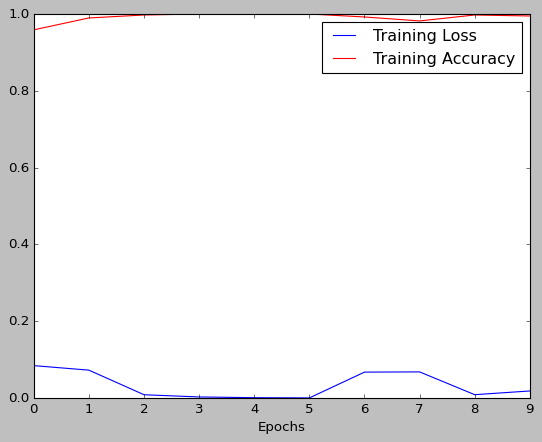

In [ ]:
#plot the training history (training loss & accuracy)
plt.plot(history.history['loss'], 'b', label='Training Loss')
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
plt.savefig(path + 'Training Accuracy vs Loss.png')
plt.show()

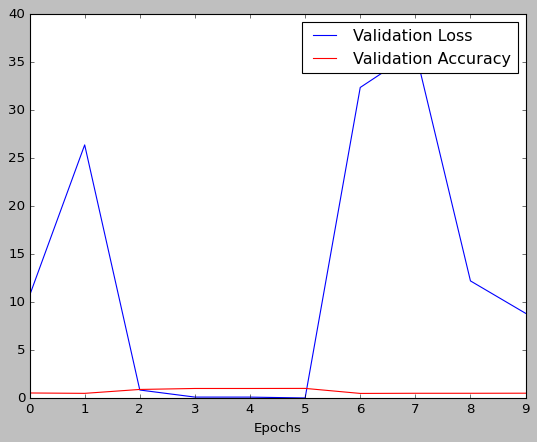

In [ ]:
#plot the training history (training loss & accuracy)
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
plt.savefig(path + 'Validation Accuracy vs Loss.png')
plt.show()

In [ ]:
# #Plot training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs = range(1, len(loss) + 1)

# plt.plot(epochs, loss, 'y', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.plot(epochs, acc, 'b', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')

# plt.title('Training History')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy & Loss')
# plt.legend()

# # plt.subplot(1,2,2)
# # plt.plot(epochs, acc, 'y', label='Training Accuracy')
# # plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# # plt.title('Training and Validation Accuracy')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()
# plt.savefig(path+'training_history.png')
# plt.show()

## Model Testing

In [ ]:
#Load the model
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/model_training/Resources/MobileNetV2.h5')
trained_model

In [ ]:
#Load and generate test dataset
test_dir = '/content/drive/MyDrive/model_training/Dataset_Split/test/'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
image_size = 224
batch_size = 32

# test_generator = test_datagen.flow_from_directory(
#                 test_dir,  # Source directory for the testing images
#                 target_size=(image_size, image_size),
#                 batch_size=batch_size,
#                 shuffle = False,
#                 class_mode='categorical')

test_generator =  test_datagen.flow_from_directory(
                test_dir,  # Source directory for the testing images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                shuffle = False,
                class_mode='categorical')

Found 30 images belonging to 2 classes.


In [ ]:
test_generator.class_indices

{'barako': 0, 'not_barako': 1}

In [ ]:
#Test the model using the test dataset
predictions = trained_model.predict(test_generator)

In [ ]:
#Raw predictions (percentages)
print(predictions)

[[0.63273805 0.36726195]
 [0.45886928 0.5411307 ]
 [0.50222355 0.49777648]
 [0.3451827  0.65481734]
 [0.67180175 0.3281982 ]
 [0.3072073  0.6927927 ]
 [0.70551515 0.29448485]
 [0.56730807 0.43269193]
 [0.30289885 0.6971012 ]
 [0.3969283  0.6030717 ]
 [0.35036638 0.64963365]
 [0.47800368 0.5219963 ]
 [0.34918457 0.65081537]
 [0.36982375 0.6301763 ]
 [0.20608135 0.79391867]
 [0.30051684 0.6994831 ]
 [0.32474202 0.675258  ]
 [0.1846781  0.81532186]
 [0.23538673 0.7646133 ]
 [0.16989806 0.8301019 ]
 [0.26558483 0.73441523]
 [0.29951826 0.7004818 ]
 [0.2801893  0.7198107 ]
 [0.28764024 0.7123597 ]
 [0.38532516 0.6146748 ]
 [0.12775314 0.87224686]
 [0.18858543 0.81141454]
 [0.28966933 0.71033067]
 [0.36892262 0.6310774 ]
 [0.18890445 0.81109554]]


In [ ]:
score = trained_model.evaluate_generator(test_generator, steps=3)
print("[INFO] accuracy: {:.2f}%".format(score[1]*100))
print("[INFO] loss:",score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 66.67%
[INFO] loss: 0.5866636037826538


## Visualization

In [ ]:
test_file_names = test_generator.filenames  # sequential list of name of test files of each sample
test_labels = test_generator.labels # is a sequential list  of test labels for each image sample
class_dict = test_generator.class_indices # a dictionary where key is the class name and value is the corresponding label for the class

print(class_dict ); print('\n') # have a look at the dictionary
new_dict={} 

#Create array for storage
pred_ind = [] #numerical values

predicted_classes = []
true_classes = []
filenames = []

for key in class_dict: #set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key

print('    PREDICTED CLASS      TRUE CLASS            FILENAME ' ) # adjust spacing based on your class names
for i, p in enumerate(predictions):
    pred_index = np.argmax(p) #get the index that has the highest probability
    pred_ind.append(np.argmax(p)) #store the predicted class indices (numerical)

    pred_class = new_dict[pred_index]  # find the predicted class based on the index
    predicted_classes.append(pred_class) #store the actual predicted classes (string)

    true_class = new_dict[test_labels[i]] # use the test label to get the true class of the test file
    true_classes.append(true_class)

    file = test_file_names[i]
    filenames.append(file)

    print(f'    {pred_class}       {true_class}       {file}')

{'barako': 0, 'not_barako': 1}


    PREDICTED CLASS      TRUE CLASS            FILENAME 
    barako       barako       barako/liberica_beans (10).jpg
    not_barako       barako       barako/liberica_beans (11).jpg
    barako       barako       barako/liberica_beans (111).jpg
    not_barako       barako       barako/liberica_beans (112).jpg
    barako       barako       barako/liberica_beans (122).jpg
    not_barako       barako       barako/liberica_beans (134).jpg
    barako       barako       barako/liberica_beans (152).jpg
    barako       barako       barako/liberica_beans (159).jpg
    not_barako       barako       barako/liberica_beans (18).jpg
    not_barako       barako       barako/liberica_beans (185).jpg
    not_barako       barako       barako/liberica_beans (204).jpg
    not_barako       barako       barako/liberica_beans (222).jpg
    not_barako       barako       barako/liberica_beans (232).jpg
    not_barako       barako       barako/liberica_beans (53).jpg
    not_ba

In [ ]:
#Save the prediction into a more readable format
pred_df = pd.DataFrame(np.column_stack([filenames, true_classes, predicted_classes]), columns=['Filename', 'True Class', 'Predicted Class'])
pred_df.to_csv('/content/drive/MyDrive/model_training/Resources/predictions.csv', index=False) #Save to a CSV file

## CONFUSION MATRIX

Confusion matrix, without normalization

                          Classification Report
              precision    recall  f1-score   support

 no_liberica       1.00      1.00      1.00        15
yes_liberica       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



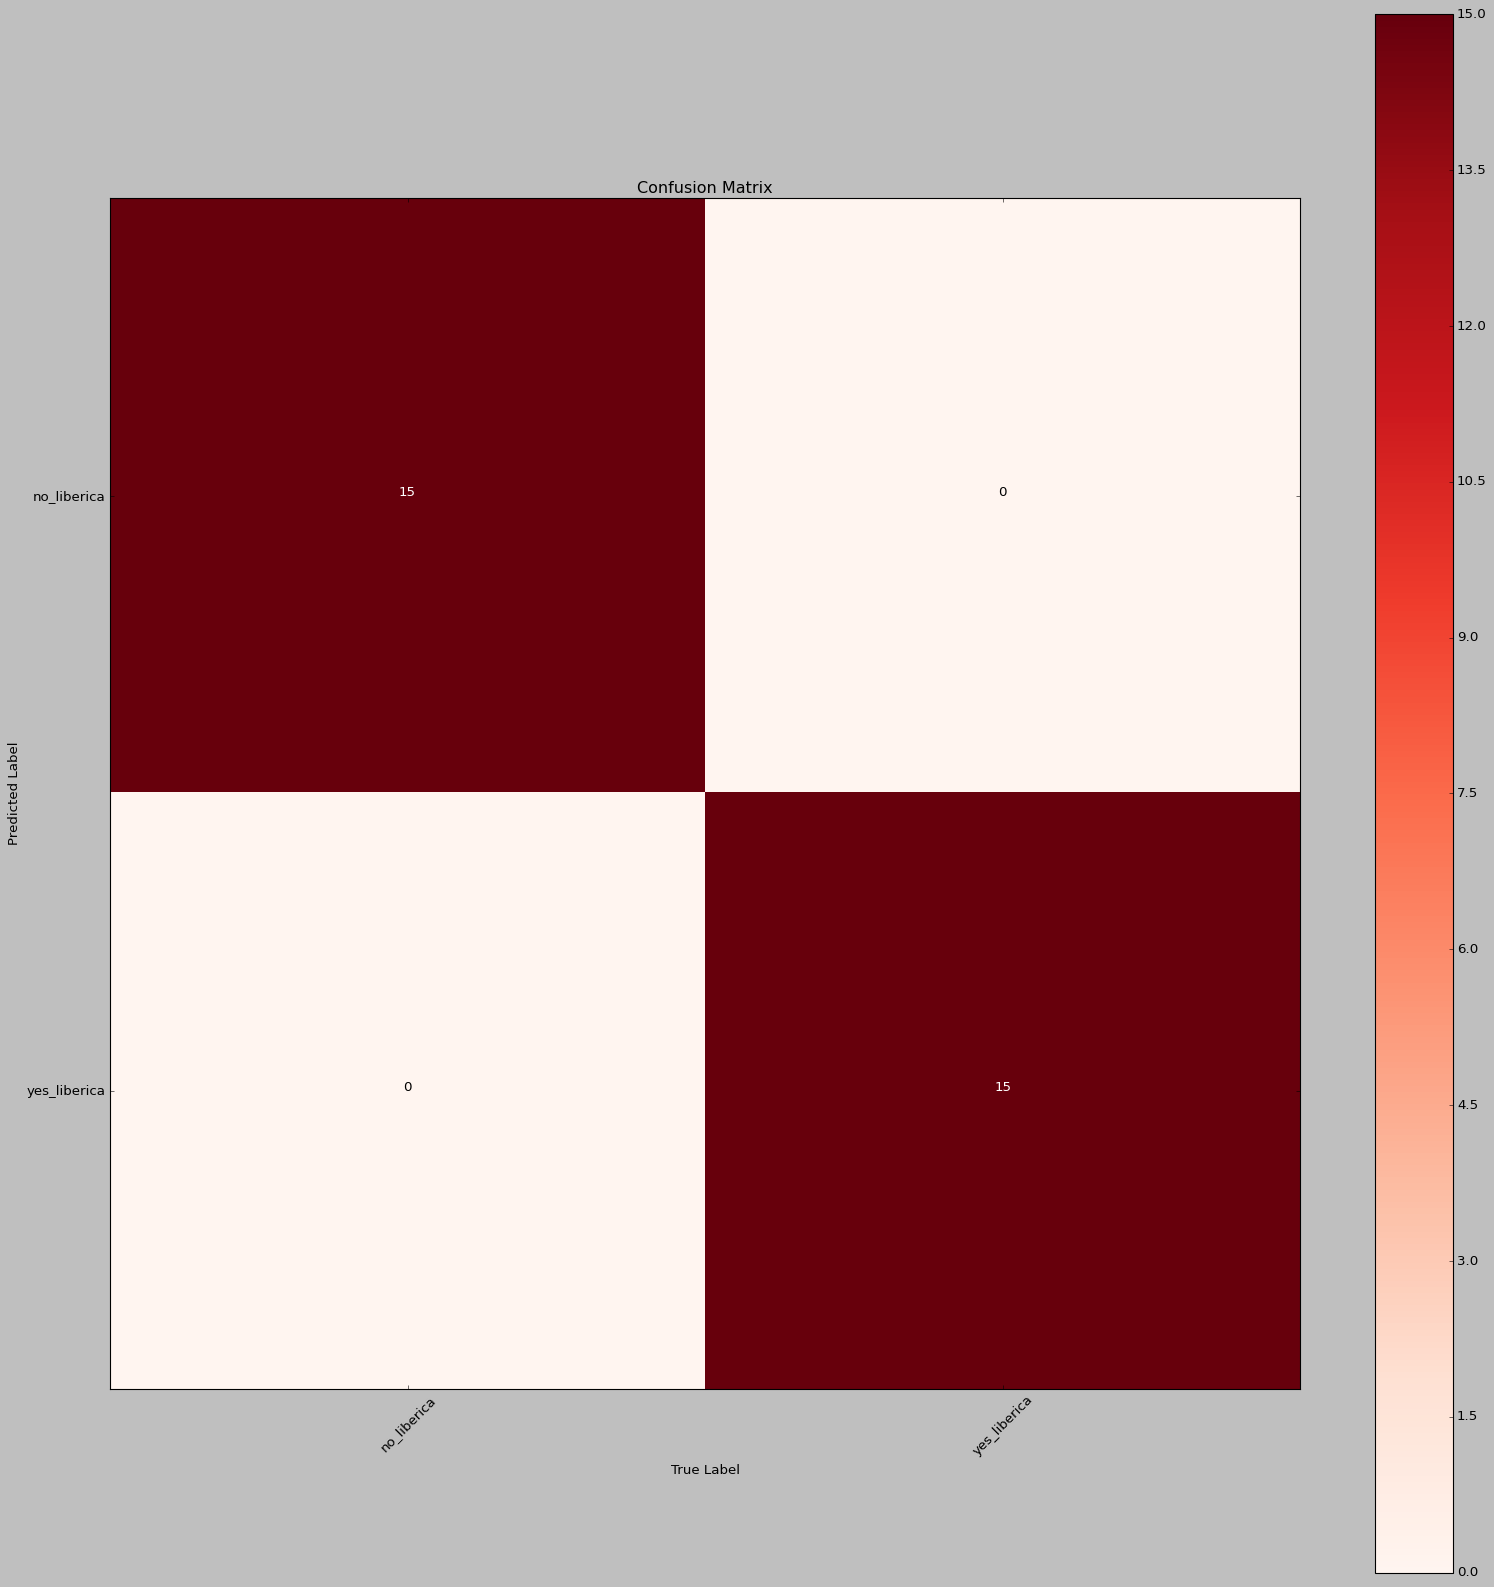

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix\n")
    else:
        print('Confusion matrix, without normalization\n')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')

    # %cd = /content/drive/MyDrive/thesis-02/resource_files/
    plt.savefig('/content/drive/MyDrive/model_training_v2/Resources/Confusion Matrix.png')

#shuffle=False
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

#Confusion Matrix
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)

#print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('                          Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))